In [1]:
import matplotlib.pyplot as plt
import incense
from common.helper.config import parseMongoConfig
from pathlib import Path

loader = incense.ExperimentLoader(**parseMongoConfig('../config.ini', adapt='IncenseExperimentLoader'))
query = {
    'lara': {
        '$and': [
            {
                'experiment.name': 'CNN-IMU_LARa'
            },
            {
                '_id': {
                    '$gte': 97
                }
            },
            {
                'status': 'COMPLETED'
            },
            {
                'meta.my_meta.runner': 'cnn_imu_rerun_best.py'
            },
        ]
    },
    'pamap2': {
        '$and': [
            {
                'experiment.name': 'CNN-IMU_Pamap2(activity_labels)'
            },
            {
                '_id': {
                    '$gte': 97
                }
            },
            {
                'status': 'COMPLETED'
            },
            {
                'meta.my_meta.runner': 'cnn_imu_rerun_best.py'
            },
        ]
    },
    'opportunity': {
        '$and': [
            {
                'experiment.name': 'CNN-IMU_Opportunity-Locomotion'
            },
            {
                '_id': {
                    '$gte': 97
                }
            },
            {
                'status': 'COMPLETED'
            },
            {
                'meta.my_meta.runner': 'cnn_imu_rerun_best.py'
            },
        ]
    }
}
experiments = { n : loader.find(q)[0] for n, q in query.items() }
print(f'Considering Experiments: {({n : e.to_dict()["_id"] for n,e in experiments.items()})}')

def figurePath(filename : str) -> str:
  directory = Path('figures')
  base = Path(filename)
  directory.mkdir(parents=True, exist_ok=True)
  return str(directory.joinpath(base))

Considering Experiments: {'lara': 786, 'pamap2': 788, 'opportunity': 787}


In [2]:
for n, e in experiments.items():
  print(f'{n} : {e.to_dict()["config"]["batch_size"]}')

lara : 128
pamap2 : 128
opportunity : 128


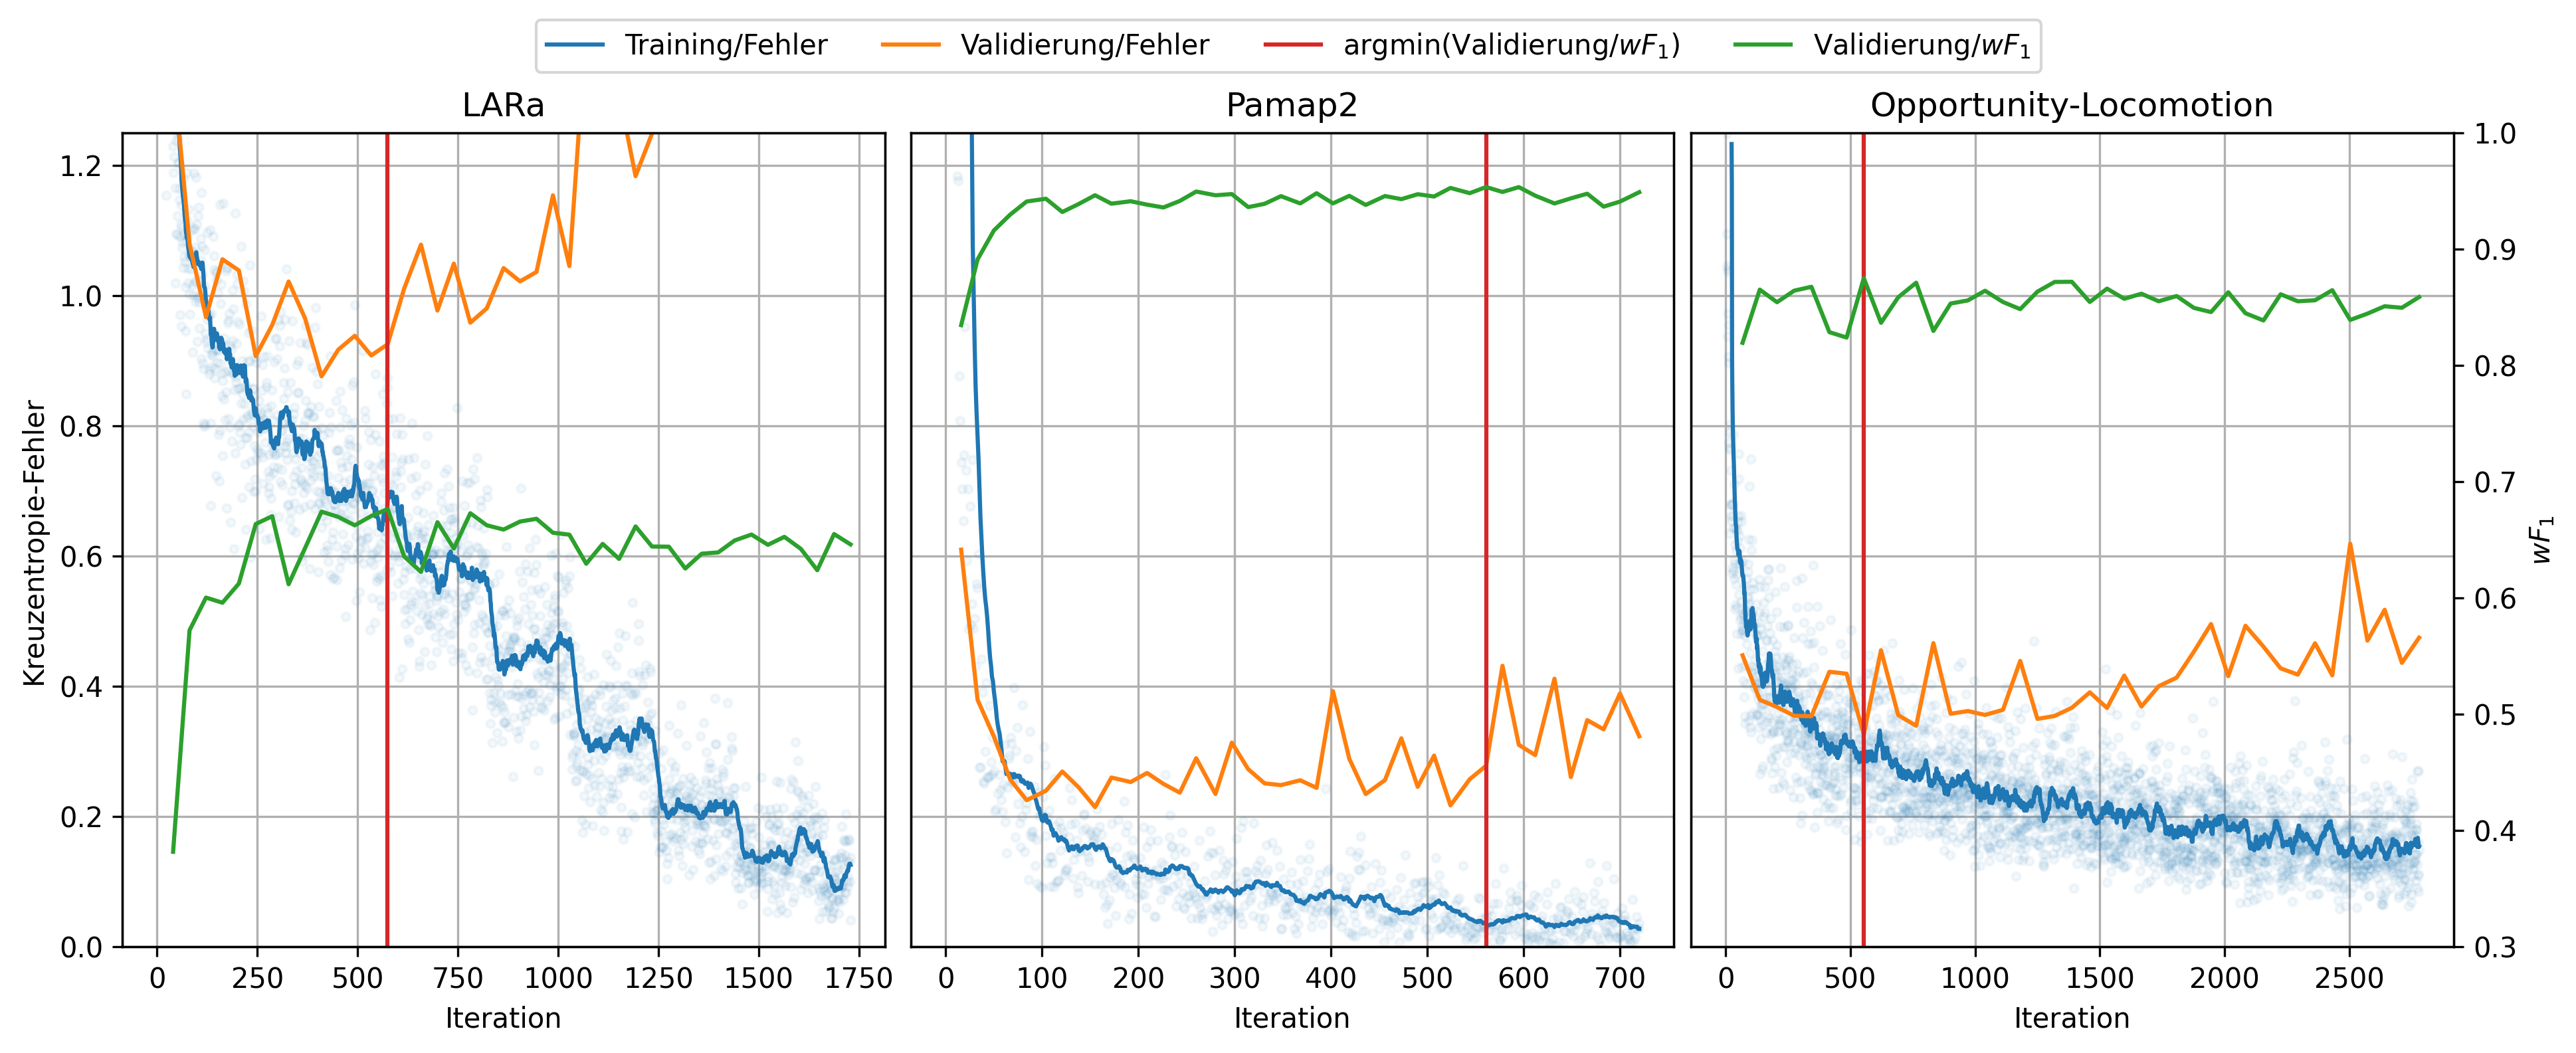

In [9]:
import pandas as pd
from matplotlib import cm
cmap = cm.get_cmap('tab10')

friendly = {
  'lara' : 'LARa',
  'pamap2' : 'Pamap2',
  'opportunity' : 'Opportunity-Locomotion',
}

fig, axs = plt.subplots(1,3, sharey=True, constrained_layout=True)
fig.set_dpi(300)
fig.set_figwidth(fig.get_figwidth() * 2)
handles = None
labels = None
taxes = []
axes = []
for ax, (n, e) in zip(axs, experiments.items()):
  train : pd.Series  = e.metrics['train/loss']
  val : pd.Series  = e.metrics['validation/loss']
  wf1 : pd.Series  = e.metrics['validation/wf1']

  tax = ax.twinx()
  tax.set_ylim(0.3,1)
  taxes.append(tax)
  axes.append(ax)
  ax.set_ylim(0, 1.25)

  train.rolling(window=25).mean().plot(ax=ax, color=cmap(0), label='Training/Fehler')
  train.plot(style='.', ax=ax, label='', alpha=0.05, color=cmap(0))
  val.plot(ax=ax, color=cmap(1), label='Validierung/Fehler')
  wf1.plot(ax=tax, color=cmap(2), label='Validierung/$wF_1$')


  ax.axvline(wf1.idxmax(), color=cmap(3), label='argmin(Validierung/$wF_1$)')
  ax.set_ylabel('Kreuzentropie-Fehler')
  ax.set_xlabel(f'Iteration')
  ax.set_title(friendly[n])
  ax.grid()
  handles, labels = ax.get_legend_handles_labels()
  h2, l2 = tax.get_legend_handles_labels()
  handles.extend(h2)
  labels.extend(l2)

for ax in taxes[:-1]:
  ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
for ax in axes[1:]:
  ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
taxes[-1].set_ylabel('$wF_1$')

fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0,0,1,1.08))
fig.savefig(figurePath('train_combined.pdf'), bbox_inches='tight')
fig.show()

In [4]:
for n, e in experiments.items():
  print(n)
  wf1 : pd.Series = e.metrics['test/wf1'] * 100
  acc : pd.Series = e.metrics['test/acc'] * 100
  bt : pd.Series = e.metrics['test/batch_time'] * 1000
  cfg = e.to_dict()['config']


  
  print(f'wF1 = {wf1.values[wf1.argmax()]}\nacc = {acc.values[wf1.argmax()]}')
  print(f'bt : mu={bt.mean()}, sig={bt.std()}')
  print(f'B = {cfg["cnn_imu_blocks"]}')
  print(f'FC = {cfg["cnn_imu_fc_features"]}')
  print(f'BS = {cfg["batch_size"]}')
  print(f'Window = {cfg["window"]}, Stride = {cfg["stride"]}')
  print(f'Optim = {cfg["optimizer"]}, lr = {cfg["lr"]}, lr = {cfg["lr"]}')
  print(f'Patience = {cfg["loss_patience"]}, val_interval={cfg["validation_interval"]}')

lara
wF1 = 72.21230268478394
acc = 73.34179282188416
bt : mu=226.75060941452995, sig=1.7888982274755618
B = 2
FC = 512
BS = 128
Window = 100, Stride = 12
Optim = Adam, lr = 0.001, lr = 0.001
Patience = 32, val_interval=0.2
pamap2
wF1 = 95.45150399208069
acc = 95.13343572616577
bt : mu=293.6364617612627, sig=4.5848208710073655
B = 2
FC = 512
BS = 128
Window = 100, Stride = 33
Optim = Adam, lr = 0.001, lr = 0.001
Patience = 32, val_interval=0.2
opportunity
wF1 = 85.67395210266113
acc = 85.8491837978363
bt : mu=217.83710140629677, sig=8.060614784460078
B = 2
FC = 256
BS = 128
Window = 24, Stride = 12
Optim = Adam, lr = 0.001, lr = 0.001
Patience = 32, val_interval=0.2
